In [1]:
import numpy as np

In [2]:
class Node():
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        self.value = None
        self.gradients = {}
        
        for n in self.inputs:
            n.outputs.append(self)
            
    def forward(self):
        return NotImplemented
    
    def backward(self):
        return NotImplemented

In [3]:
class Input(Node):
    def __init__(self):
        Node.__init__(self)
        
    def forward(self, value=None):
        if value is not None:
            self.value = value
                
    def backward(self):
        self.gradients = {self: 0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1

In [4]:
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
        
    def forward(self):
        self.value = sum(map(lambda n : n.value, self.inputs))

In [5]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

In [6]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
        
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * self.partial

In [7]:
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
        
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff ** 2)
        
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

In [8]:
def forward_and_backward(graph):
    for n in graph:
        n.forward()
    for n in graph[::-1]:
        n.backward()

In [9]:
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'out': set(), 'in': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'out': set(), 'in': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [10]:
def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [11]:
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
import matplotlib.pyplot as plt

In [12]:
losses = []
data = load_boston()

X_ = data['data']
y_ = data['target']

In [13]:
type(X_)

numpy.ndarray

In [14]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [15]:
n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [16]:
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

In [17]:
l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

In [18]:
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

In [19]:
epochs = 5000
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

In [20]:
trainables = [W1, b1, W2, b2]

In [21]:
graph = topological_sort(feed_dict)

In [22]:
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
        forward_and_backward(graph)
        
        rate = 1e-2
        sgd_update(trainables, rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('epoch: {}, loss: {:.3f}'.format(i + 1, loss / steps_per_epoch))
        losses.append(loss)

epoch: 1, loss: 171.249
epoch: 101, loss: 6.519
epoch: 201, loss: 5.984
epoch: 301, loss: 5.331
epoch: 401, loss: 4.264
epoch: 501, loss: 3.728
epoch: 601, loss: 4.039
epoch: 701, loss: 3.496
epoch: 801, loss: 2.996
epoch: 901, loss: 3.539
epoch: 1001, loss: 3.352
epoch: 1101, loss: 3.390
epoch: 1201, loss: 3.645
epoch: 1301, loss: 3.112
epoch: 1401, loss: 3.000
epoch: 1501, loss: 2.918
epoch: 1601, loss: 3.019
epoch: 1701, loss: 3.116
epoch: 1801, loss: 3.464
epoch: 1901, loss: 3.295
epoch: 2001, loss: 3.003
epoch: 2101, loss: 3.153
epoch: 2201, loss: 3.093
epoch: 2301, loss: 2.970
epoch: 2401, loss: 3.479
epoch: 2501, loss: 2.538
epoch: 2601, loss: 3.092
epoch: 2701, loss: 3.029
epoch: 2801, loss: 2.230
epoch: 2901, loss: 3.115
epoch: 3001, loss: 2.899
epoch: 3101, loss: 2.710
epoch: 3201, loss: 3.208
epoch: 3301, loss: 2.883
epoch: 3401, loss: 2.615
epoch: 3501, loss: 2.960
epoch: 3601, loss: 3.185
epoch: 3701, loss: 2.829
epoch: 3801, loss: 2.914
epoch: 3901, loss: 2.988
epoch: 400

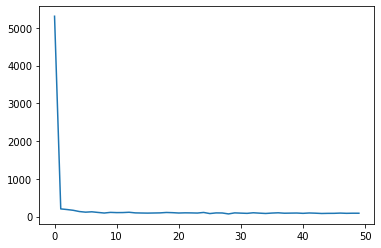

In [23]:
plt.plot(range(len(losses)), losses)

In [24]:
W2.value

array([[ 5.80142364],
       [ 7.84069408],
       [ 6.11942836],
       [ 5.19603234],
       [14.93699411],
       [ 5.79932031],
       [-6.20086646],
       [ 7.7379011 ],
       [ 6.98957705],
       [ 8.15931376]])

In [25]:
X_ = data['data']

In [26]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [27]:
import keras
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

In [28]:
model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [29]:
model.fit(X_, y_, epochs=5000, batch_size=32)


Epoch 1/5000
506/506 [==============================] - 0s 779us/step - loss: 166.8288 - mse: 166.8288
Epoch 2/5000
506/506 [==============================] - 0s 112us/step - loss: 84.3113 - mse: 84.3113
Epoch 3/5000
506/506 [==============================] - 0s 99us/step - loss: 80.6010 - mse: 80.6010
Epoch 4/5000
506/506 [==============================] - 0s 102us/step - loss: 77.0485 - mse: 77.0485
Epoch 5/5000
506/506 [==============================] - 0s 99us/step - loss: 78.6642 - mse: 78.6641
Epoch 6/5000
506/506 [==============================] - 0s 99us/step - loss: 78.9337 - mse: 78.9337
Epoch 7/5000
506/506 [==============================] - 0s 107us/step - loss: 80.9918 - mse: 80.9918
Epoch 8/5000
506/506 [==============================] - 0s 101us/step - loss: 82.4037 - mse: 82.4037
Epoch 9/5000
506/506 [==============================] - 0s 93us/step - loss: 81.0433 - mse: 81.0434
Epoch 10/5000
506/506 [==============================] - 0s 99us/step - loss: 75.5399 - mse:

506/506 [==============================] - 0s 87us/step - loss: 85.7839 - mse: 85.7839
Epoch 81/5000
506/506 [==============================] - 0s 87us/step - loss: 85.2912 - mse: 85.2912
Epoch 82/5000
506/506 [==============================] - 0s 89us/step - loss: 85.0711 - mse: 85.0711
Epoch 83/5000
506/506 [==============================] - 0s 89us/step - loss: 85.4764 - mse: 85.4764
Epoch 84/5000
506/506 [==============================] - 0s 79us/step - loss: 85.5072 - mse: 85.5072
Epoch 85/5000
506/506 [==============================] - 0s 79us/step - loss: 85.0000 - mse: 85.0000
Epoch 86/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9549 - mse: 84.9549
Epoch 87/5000
506/506 [==============================] - 0s 77us/step - loss: 85.0886 - mse: 85.0886
Epoch 88/5000
506/506 [==============================] - 0s 79us/step - loss: 85.6743 - mse: 85.6743
Epoch 89/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9037 - mse: 84.9037
Epoc

506/506 [==============================] - 0s 83us/step - loss: 72.7023 - mse: 72.7023
Epoch 161/5000
506/506 [==============================] - 0s 83us/step - loss: 70.5084 - mse: 70.5085
Epoch 162/5000
506/506 [==============================] - 0s 79us/step - loss: 77.4467 - mse: 77.4467
Epoch 163/5000
506/506 [==============================] - 0s 79us/step - loss: 87.4763 - mse: 87.4763
Epoch 164/5000
506/506 [==============================] - 0s 81us/step - loss: 85.4602 - mse: 85.4602
Epoch 165/5000
506/506 [==============================] - 0s 83us/step - loss: 86.5579 - mse: 86.5579
Epoch 166/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0780 - mse: 85.0780
Epoch 167/5000
506/506 [==============================] - 0s 83us/step - loss: 85.0155 - mse: 85.0155
Epoch 168/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9931 - mse: 84.9931
Epoch 169/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8549 - mse: 84.

506/506 [==============================] - 0s 85us/step - loss: 84.8264 - mse: 84.8264
Epoch 241/5000
506/506 [==============================] - 0s 97us/step - loss: 84.9512 - mse: 84.9512
Epoch 242/5000
506/506 [==============================] - 0s 90us/step - loss: 84.8658 - mse: 84.8657
Epoch 243/5000
506/506 [==============================] - 0s 89us/step - loss: 84.9854 - mse: 84.9854
Epoch 244/5000
506/506 [==============================] - 0s 89us/step - loss: 85.1440 - mse: 85.1440
Epoch 245/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7862 - mse: 84.7862
Epoch 246/5000
506/506 [==============================] - 0s 91us/step - loss: 84.8284 - mse: 84.8284
Epoch 247/5000
506/506 [==============================] - 0s 91us/step - loss: 84.9079 - mse: 84.9079
Epoch 248/5000
506/506 [==============================] - 0s 87us/step - loss: 84.6086 - mse: 84.6086
Epoch 249/5000
506/506 [==============================] - 0s 95us/step - loss: 84.7321 - mse: 84.

506/506 [==============================] - 0s 97us/step - loss: 84.7577 - mse: 84.7577
Epoch 321/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8073 - mse: 84.8073
Epoch 322/5000
506/506 [==============================] - 0s 87us/step - loss: 85.2788 - mse: 85.2788
Epoch 323/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9220 - mse: 84.9220
Epoch 324/5000
506/506 [==============================] - 0s 91us/step - loss: 84.8704 - mse: 84.8704
Epoch 325/5000
506/506 [==============================] - 0s 108us/step - loss: 84.7029 - mse: 84.7029
Epoch 326/5000
506/506 [==============================] - 0s 89us/step - loss: 85.1430 - mse: 85.1430
Epoch 327/5000
506/506 [==============================] - 0s 95us/step - loss: 85.0191 - mse: 85.0191
Epoch 328/5000
506/506 [==============================] - 0s 89us/step - loss: 85.1238 - mse: 85.1238
Epoch 329/5000
506/506 [==============================] - 0s 101us/step - loss: 85.0690 - mse: 8

506/506 [==============================] - 0s 91us/step - loss: 84.8277 - mse: 84.8277
Epoch 401/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9178 - mse: 84.9178
Epoch 402/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8008 - mse: 84.8008
Epoch 403/5000
506/506 [==============================] - 0s 87us/step - loss: 84.4989 - mse: 84.4989
Epoch 404/5000
506/506 [==============================] - 0s 87us/step - loss: 85.0316 - mse: 85.0316
Epoch 405/5000
506/506 [==============================] - 0s 79us/step - loss: 84.5344 - mse: 84.5344
Epoch 406/5000
506/506 [==============================] - 0s 85us/step - loss: 85.2687 - mse: 85.2687
Epoch 407/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7800 - mse: 84.7800
Epoch 408/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8535 - mse: 84.8535
Epoch 409/5000
506/506 [==============================] - 0s 101us/step - loss: 84.7671 - mse: 84

506/506 [==============================] - 0s 87us/step - loss: 84.8417 - mse: 84.8417
Epoch 481/5000
506/506 [==============================] - 0s 85us/step - loss: 85.1023 - mse: 85.1023
Epoch 482/5000
506/506 [==============================] - 0s 83us/step - loss: 85.2264 - mse: 85.2264
Epoch 483/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8504 - mse: 84.8504
Epoch 484/5000
506/506 [==============================] - 0s 93us/step - loss: 85.0152 - mse: 85.0152
Epoch 485/5000
506/506 [==============================] - 0s 91us/step - loss: 85.2257 - mse: 85.2257
Epoch 486/5000
506/506 [==============================] - 0s 83us/step - loss: 85.2288 - mse: 85.2289
Epoch 487/5000
506/506 [==============================] - 0s 79us/step - loss: 85.2783 - mse: 85.2783
Epoch 488/5000
506/506 [==============================] - ETA: 0s - loss: 60.9693 - mse: 60.969 - 0s 89us/step - loss: 84.9748 - mse: 84.9748
Epoch 489/5000
506/506 [==============================] -

506/506 [==============================] - 0s 85us/step - loss: 85.2033 - mse: 85.2033
Epoch 561/5000
506/506 [==============================] - 0s 95us/step - loss: 84.7319 - mse: 84.7319
Epoch 562/5000
506/506 [==============================] - 0s 87us/step - loss: 84.8304 - mse: 84.8304
Epoch 563/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7063 - mse: 84.7063
Epoch 564/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7576 - mse: 84.7576
Epoch 565/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6481 - mse: 84.6481
Epoch 566/5000
506/506 [==============================] - 0s 87us/step - loss: 85.0733 - mse: 85.0733
Epoch 567/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9985 - mse: 84.9985
Epoch 568/5000
506/506 [==============================] - 0s 87us/step - loss: 84.8490 - mse: 84.8490
Epoch 569/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8653 - mse: 84.

506/506 [==============================] - 0s 85us/step - loss: 84.8836 - mse: 84.8836
Epoch 641/5000
506/506 [==============================] - 0s 97us/step - loss: 85.3223 - mse: 85.3223
Epoch 642/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0554 - mse: 85.0554
Epoch 643/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8648 - mse: 84.8648
Epoch 644/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9869 - mse: 84.9869
Epoch 645/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8202 - mse: 84.8202
Epoch 646/5000
506/506 [==============================] - 0s 87us/step - loss: 84.8148 - mse: 84.8148
Epoch 647/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8939 - mse: 84.8939
Epoch 648/5000
506/506 [==============================] - 0s 91us/step - loss: 85.4795 - mse: 85.4795
Epoch 649/5000
506/506 [==============================] - 0s 89us/step - loss: 84.6179 - mse: 84.

506/506 [==============================] - 0s 85us/step - loss: 84.7138 - mse: 84.7138
Epoch 721/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6455 - mse: 84.6455
Epoch 722/5000
506/506 [==============================] - 0s 83us/step - loss: 84.5840 - mse: 84.5840
Epoch 723/5000
506/506 [==============================] - 0s 81us/step - loss: 85.1293 - mse: 85.1293
Epoch 724/5000
506/506 [==============================] - 0s 79us/step - loss: 84.6412 - mse: 84.6412
Epoch 725/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7211 - mse: 84.7211
Epoch 726/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7176 - mse: 84.7176
Epoch 727/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8677 - mse: 84.8677
Epoch 728/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8389 - mse: 84.8389
Epoch 729/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7466 - mse: 84.

506/506 [==============================] - 0s 93us/step - loss: 84.7060 - mse: 84.7060
Epoch 801/5000
506/506 [==============================] - 0s 91us/step - loss: 84.8219 - mse: 84.8219
Epoch 802/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7722 - mse: 84.7722
Epoch 803/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8633 - mse: 84.8633
Epoch 804/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7560 - mse: 84.7560
Epoch 805/5000
506/506 [==============================] - 0s 91us/step - loss: 84.9602 - mse: 84.9602
Epoch 806/5000
506/506 [==============================] - 0s 87us/step - loss: 85.6586 - mse: 85.6586
Epoch 807/5000
506/506 [==============================] - 0s 96us/step - loss: 84.9392 - mse: 84.9392
Epoch 808/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8426 - mse: 84.8426
Epoch 809/5000
506/506 [==============================] - 0s 89us/step - loss: 85.1385 - mse: 85.

506/506 [==============================] - 0s 83us/step - loss: 85.3904 - mse: 85.3904
Epoch 881/5000
506/506 [==============================] - 0s 84us/step - loss: 85.2884 - mse: 85.2884
Epoch 882/5000
506/506 [==============================] - 0s 81us/step - loss: 85.1518 - mse: 85.1518
Epoch 883/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9548 - mse: 84.9548
Epoch 884/5000
506/506 [==============================] - 0s 83us/step - loss: 85.5893 - mse: 85.5892
Epoch 885/5000
506/506 [==============================] - 0s 93us/step - loss: 84.9036 - mse: 84.9036
Epoch 886/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9669 - mse: 84.9669
Epoch 887/5000
506/506 [==============================] - 0s 85us/step - loss: 84.5619 - mse: 84.5619
Epoch 888/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1846 - mse: 85.1845
Epoch 889/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8002 - mse: 84.

506/506 [==============================] - 0s 89us/step - loss: 84.6207 - mse: 84.6207
Epoch 961/5000
506/506 [==============================] - 0s 87us/step - loss: 85.0975 - mse: 85.0975
Epoch 962/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7208 - mse: 84.7208
Epoch 963/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7746 - mse: 84.7746
Epoch 964/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7773 - mse: 84.7773
Epoch 965/5000
506/506 [==============================] - 0s 77us/step - loss: 84.8613 - mse: 84.8613
Epoch 966/5000
506/506 [==============================] - 0s 87us/step - loss: 85.4177 - mse: 85.4177
Epoch 967/5000
506/506 [==============================] - 0s 97us/step - loss: 85.0635 - mse: 85.0635
Epoch 968/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8882 - mse: 84.8882
Epoch 969/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8541 - mse: 84.

506/506 [==============================] - 0s 83us/step - loss: 84.4952 - mse: 84.4952
Epoch 1040/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9343 - mse: 84.9343
Epoch 1041/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9676 - mse: 84.9676
Epoch 1042/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9852 - mse: 84.9852
Epoch 1043/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7224 - mse: 84.7224
Epoch 1044/5000
506/506 [==============================] - 0s 83us/step - loss: 85.5300 - mse: 85.5300
Epoch 1045/5000
506/506 [==============================] - 0s 85us/step - loss: 84.4520 - mse: 84.4520
Epoch 1046/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0861 - mse: 85.0861
Epoch 1047/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8330 - mse: 84.8330
Epoch 1048/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6300 -

506/506 [==============================] - 0s 81us/step - loss: 85.1748 - mse: 85.1748
Epoch 1119/5000
506/506 [==============================] - 0s 87us/step - loss: 84.8680 - mse: 84.8680
Epoch 1120/5000
506/506 [==============================] - 0s 93us/step - loss: 85.1119 - mse: 85.1119
Epoch 1121/5000
506/506 [==============================] - 0s 87us/step - loss: 84.8766 - mse: 84.8766
Epoch 1122/5000
506/506 [==============================] - 0s 89us/step - loss: 85.7310 - mse: 85.7310
Epoch 1123/5000
506/506 [==============================] - 0s 101us/step - loss: 84.9945 - mse: 84.9944
Epoch 1124/5000
506/506 [==============================] - 0s 118us/step - loss: 85.2218 - mse: 85.2218
Epoch 1125/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8317 - mse: 84.8317
Epoch 1126/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9131 - mse: 84.9131
Epoch 1127/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9705

506/506 [==============================] - 0s 85us/step - loss: 85.1503 - mse: 85.1503
Epoch 1198/5000
506/506 [==============================] - 0s 81us/step - loss: 85.5741 - mse: 85.5741
Epoch 1199/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8758 - mse: 84.8758
Epoch 1200/5000
506/506 [==============================] - 0s 85us/step - loss: 85.3865 - mse: 85.3865
Epoch 1201/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6252 - mse: 84.6252
Epoch 1202/5000
506/506 [==============================] - 0s 81us/step - loss: 85.2506 - mse: 85.2506
Epoch 1203/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7595 - mse: 84.7595
Epoch 1204/5000
506/506 [==============================] - 0s 95us/step - loss: 85.0089 - mse: 85.0090
Epoch 1205/5000
506/506 [==============================] - 0s 93us/step - loss: 84.9544 - mse: 84.9544
Epoch 1206/5000
506/506 [==============================] - 0s 89us/step - loss: 84.6476 -

506/506 [==============================] - 0s 81us/step - loss: 84.4855 - mse: 84.4855
Epoch 1277/5000
506/506 [==============================] - 0s 81us/step - loss: 85.3112 - mse: 85.3112
Epoch 1278/5000
506/506 [==============================] - 0s 81us/step - loss: 84.4843 - mse: 84.4843
Epoch 1279/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8934 - mse: 84.8934
Epoch 1280/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7210 - mse: 84.7210
Epoch 1281/5000
506/506 [==============================] - 0s 79us/step - loss: 84.9233 - mse: 84.9233
Epoch 1282/5000
506/506 [==============================] - 0s 79us/step - loss: 85.0267 - mse: 85.0267
Epoch 1283/5000
506/506 [==============================] - 0s 85us/step - loss: 85.2173 - mse: 85.2173
Epoch 1284/5000
506/506 [==============================] - 0s 81us/step - loss: 85.3785 - mse: 85.3785
Epoch 1285/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8232 -

506/506 [==============================] - 0s 87us/step - loss: 85.1788 - mse: 85.1788
Epoch 1356/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0066 - mse: 85.0066
Epoch 1357/5000
506/506 [==============================] - 0s 93us/step - loss: 85.0677 - mse: 85.0677
Epoch 1358/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7849 - mse: 84.7849
Epoch 1359/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9555 - mse: 84.9555
Epoch 1360/5000
506/506 [==============================] - 0s 83us/step - loss: 85.2959 - mse: 85.2959
Epoch 1361/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6640 - mse: 84.6640
Epoch 1362/5000
506/506 [==============================] - 0s 83us/step - loss: 85.4710 - mse: 85.4710
Epoch 1363/5000
506/506 [==============================] - 0s 87us/step - loss: 84.5757 - mse: 84.5757
Epoch 1364/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6732 -

506/506 [==============================] - 0s 85us/step - loss: 85.2121 - mse: 85.2121
Epoch 1435/5000
506/506 [==============================] - 0s 79us/step - loss: 84.6552 - mse: 84.6552
Epoch 1436/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9951 - mse: 84.9951
Epoch 1437/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9320 - mse: 84.9320
Epoch 1438/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7527 - mse: 84.7527
Epoch 1439/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8563 - mse: 84.8563
Epoch 1440/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6299 - mse: 84.6299
Epoch 1441/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8543 - mse: 84.8543
Epoch 1442/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9037 - mse: 84.9037
Epoch 1443/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8377 -

506/506 [==============================] - 0s 81us/step - loss: 84.5672 - mse: 84.5672
Epoch 1514/5000
506/506 [==============================] - 0s 87us/step - loss: 85.0098 - mse: 85.0098
Epoch 1515/5000
506/506 [==============================] - 0s 79us/step - loss: 84.4282 - mse: 84.4282
Epoch 1516/5000
506/506 [==============================] - 0s 89us/step - loss: 85.4114 - mse: 85.4114
Epoch 1517/5000
506/506 [==============================] - 0s 79us/step - loss: 85.3338 - mse: 85.3338
Epoch 1518/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7920 - mse: 84.7920
Epoch 1519/5000
506/506 [==============================] - 0s 89us/step - loss: 84.6268 - mse: 84.6268
Epoch 1520/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6922 - mse: 84.6922
Epoch 1521/5000
506/506 [==============================] - 0s 82us/step - loss: 84.7407 - mse: 84.7406
Epoch 1522/5000
506/506 [==============================] - 0s 79us/step - loss: 84.9641 -

506/506 [==============================] - 0s 85us/step - loss: 84.4328 - mse: 84.4328
Epoch 1593/5000
506/506 [==============================] - 0s 83us/step - loss: 85.6355 - mse: 85.6355
Epoch 1594/5000
506/506 [==============================] - 0s 83us/step - loss: 85.3635 - mse: 85.3635
Epoch 1595/5000
506/506 [==============================] - 0s 83us/step - loss: 85.0088 - mse: 85.0088
Epoch 1596/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8472 - mse: 84.8472
Epoch 1597/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9338 - mse: 84.9338
Epoch 1598/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8560 - mse: 84.8560
Epoch 1599/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7535 - mse: 84.7534
Epoch 1600/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7915 - mse: 84.7915
Epoch 1601/5000
506/506 [==============================] - ETA: 0s - loss: 139.5753 - mse

506/506 [==============================] - 0s 85us/step - loss: 84.6909 - mse: 84.6909
Epoch 1672/5000
506/506 [==============================] - 0s 89us/step - loss: 84.6271 - mse: 84.6271
Epoch 1673/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8459 - mse: 84.8459
Epoch 1674/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9566 - mse: 84.9566
Epoch 1675/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8533 - mse: 84.8533
Epoch 1676/5000
506/506 [==============================] - 0s 87us/step - loss: 85.0544 - mse: 85.0544
Epoch 1677/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8965 - mse: 84.8965
Epoch 1678/5000
506/506 [==============================] - 0s 83us/step - loss: 84.5480 - mse: 84.5480
Epoch 1679/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9026 - mse: 84.9026
Epoch 1680/5000
506/506 [==============================] - 0s 85us/step - loss: 84.3055 -

506/506 [==============================] - 0s 89us/step - loss: 84.8581 - mse: 84.8581
Epoch 1751/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9658 - mse: 84.9658
Epoch 1752/5000
506/506 [==============================] - 0s 85us/step - loss: 85.1575 - mse: 85.1575
Epoch 1753/5000
506/506 [==============================] - 0s 97us/step - loss: 84.6981 - mse: 84.6981
Epoch 1754/5000
506/506 [==============================] - 0s 93us/step - loss: 84.5922 - mse: 84.5922
Epoch 1755/5000
506/506 [==============================] - 0s 95us/step - loss: 84.8730 - mse: 84.8730
Epoch 1756/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0359 - mse: 85.0359
Epoch 1757/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9505 - mse: 84.9505
Epoch 1758/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6782 - mse: 84.6782
Epoch 1759/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0824 -

506/506 [==============================] - 0s 81us/step - loss: 84.4002 - mse: 84.4002
Epoch 1830/5000
506/506 [==============================] - 0s 85us/step - loss: 85.4957 - mse: 85.4957
Epoch 1831/5000
506/506 [==============================] - 0s 83us/step - loss: 84.5809 - mse: 84.5809
Epoch 1832/5000
506/506 [==============================] - 0s 79us/step - loss: 85.4656 - mse: 85.4656
Epoch 1833/5000
506/506 [==============================] - 0s 79us/step - loss: 85.2085 - mse: 85.2085
Epoch 1834/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7753 - mse: 84.7753
Epoch 1835/5000
506/506 [==============================] - 0s 79us/step - loss: 84.9892 - mse: 84.9892
Epoch 1836/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8548 - mse: 84.8548
Epoch 1837/5000
506/506 [==============================] - 0s 77us/step - loss: 84.7315 - mse: 84.7315
Epoch 1838/5000
506/506 [==============================] - 0s 83us/step - loss: 85.0956 -

506/506 [==============================] - 0s 93us/step - loss: 85.0419 - mse: 85.0419
Epoch 1909/5000
506/506 [==============================] - 0s 89us/step - loss: 85.2632 - mse: 85.2632
Epoch 1910/5000
506/506 [==============================] - 0s 97us/step - loss: 85.0234 - mse: 85.0234
Epoch 1911/5000
506/506 [==============================] - 0s 95us/step - loss: 85.1772 - mse: 85.1772
Epoch 1912/5000
506/506 [==============================] - 0s 91us/step - loss: 84.6093 - mse: 84.6094
Epoch 1913/5000
506/506 [==============================] - 0s 91us/step - loss: 84.7918 - mse: 84.7918
Epoch 1914/5000
506/506 [==============================] - 0s 85us/step - loss: 85.3708 - mse: 85.3708
Epoch 1915/5000
506/506 [==============================] - 0s 88us/step - loss: 84.8970 - mse: 84.8970
Epoch 1916/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8246 - mse: 84.8246
Epoch 1917/5000
506/506 [==============================] - 0s 89us/step - loss: 84.4684 -

506/506 [==============================] - 0s 87us/step - loss: 84.6369 - mse: 84.6370
Epoch 1988/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6395 - mse: 84.6395
Epoch 1989/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6355 - mse: 84.6355
Epoch 1990/5000
506/506 [==============================] - 0s 83us/step - loss: 85.2747 - mse: 85.2747
Epoch 1991/5000
506/506 [==============================] - 0s 93us/step - loss: 85.9864 - mse: 85.9864
Epoch 1992/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0021 - mse: 85.0021
Epoch 1993/5000
506/506 [==============================] - 0s 89us/step - loss: 85.3197 - mse: 85.3197
Epoch 1994/5000
506/506 [==============================] - 0s 81us/step - loss: 85.2532 - mse: 85.2532
Epoch 1995/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0710 - mse: 85.0710
Epoch 1996/5000
506/506 [==============================] - 0s 80us/step - loss: 85.7424 -

506/506 [==============================] - 0s 85us/step - loss: 85.0520 - mse: 85.0520
Epoch 2067/5000
506/506 [==============================] - 0s 89us/step - loss: 85.0599 - mse: 85.0599
Epoch 2068/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7577 - mse: 84.7577
Epoch 2069/5000
506/506 [==============================] - 0s 87us/step - loss: 85.3584 - mse: 85.3584
Epoch 2070/5000
506/506 [==============================] - 0s 81us/step - loss: 85.5416 - mse: 85.5416
Epoch 2071/5000
506/506 [==============================] - 0s 81us/step - loss: 85.2018 - mse: 85.2018
Epoch 2072/5000
506/506 [==============================] - 0s 91us/step - loss: 84.7096 - mse: 84.7096
Epoch 2073/5000
506/506 [==============================] - 0s 85us/step - loss: 85.1722 - mse: 85.1722
Epoch 2074/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8324 - mse: 84.8324
Epoch 2075/5000
506/506 [==============================] - 0s 83us/step - loss: 85.2947 -

506/506 [==============================] - 0s 89us/step - loss: 84.5293 - mse: 84.5293
Epoch 2146/5000
506/506 [==============================] - 0s 84us/step - loss: 85.1218 - mse: 85.1218
Epoch 2147/5000
506/506 [==============================] - 0s 79us/step - loss: 85.6481 - mse: 85.6480
Epoch 2148/5000
506/506 [==============================] - 0s 77us/step - loss: 84.6946 - mse: 84.6946
Epoch 2149/5000
506/506 [==============================] - 0s 81us/step - loss: 85.0487 - mse: 85.0487
Epoch 2150/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7180 - mse: 84.7180
Epoch 2151/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8354 - mse: 84.8354
Epoch 2152/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7059 - mse: 84.7059
Epoch 2153/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8899 - mse: 84.8899
Epoch 2154/5000
506/506 [==============================] - 0s 77us/step - loss: 84.7034 -

506/506 [==============================] - 0s 81us/step - loss: 85.1221 - mse: 85.1221
Epoch 2225/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7739 - mse: 84.7739
Epoch 2226/5000
506/506 [==============================] - 0s 81us/step - loss: 85.3898 - mse: 85.3898
Epoch 2227/5000
506/506 [==============================] - 0s 83us/step - loss: 84.4998 - mse: 84.4998
Epoch 2228/5000
506/506 [==============================] - 0s 89us/step - loss: 84.4851 - mse: 84.4851
Epoch 2229/5000
506/506 [==============================] - 0s 79us/step - loss: 85.1330 - mse: 85.1330
Epoch 2230/5000
506/506 [==============================] - 0s 83us/step - loss: 85.3545 - mse: 85.3544
Epoch 2231/5000
506/506 [==============================] - 0s 85us/step - loss: 84.5611 - mse: 84.5611
Epoch 2232/5000
506/506 [==============================] - 0s 85us/step - loss: 85.1336 - mse: 85.1335
Epoch 2233/5000
506/506 [==============================] - 0s 89us/step - loss: 85.0556 -

506/506 [==============================] - 0s 81us/step - loss: 84.9524 - mse: 84.9524
Epoch 2304/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9285 - mse: 84.9285
Epoch 2305/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6602 - mse: 84.6602
Epoch 2306/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8618 - mse: 84.8618
Epoch 2307/5000
506/506 [==============================] - 0s 83us/step - loss: 85.2738 - mse: 85.2739
Epoch 2308/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7622 - mse: 84.7622
Epoch 2309/5000
506/506 [==============================] - 0s 82us/step - loss: 85.0574 - mse: 85.0574
Epoch 2310/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1403 - mse: 85.1403
Epoch 2311/5000
506/506 [==============================] - 0s 87us/step - loss: 84.5080 - mse: 84.5080
Epoch 2312/5000
506/506 [==============================] - 0s 93us/step - loss: 84.8873 -

506/506 [==============================] - 0s 89us/step - loss: 84.7283 - mse: 84.7282
Epoch 2383/5000
506/506 [==============================] - 0s 91us/step - loss: 85.2498 - mse: 85.2498
Epoch 2384/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6012 - mse: 84.6012
Epoch 2385/5000
506/506 [==============================] - 0s 87us/step - loss: 85.6436 - mse: 85.6435
Epoch 2386/5000
506/506 [==============================] - 0s 94us/step - loss: 84.5502 - mse: 84.5502
Epoch 2387/5000
506/506 [==============================] - 0s 87us/step - loss: 84.6130 - mse: 84.6130
Epoch 2388/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8422 - mse: 84.8422
Epoch 2389/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6476 - mse: 84.6476
Epoch 2390/5000
506/506 [==============================] - 0s 80us/step - loss: 84.7617 - mse: 84.7617
Epoch 2391/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0520 -

506/506 [==============================] - 0s 95us/step - loss: 84.8608 - mse: 84.8608
Epoch 2462/5000
506/506 [==============================] - 0s 85us/step - loss: 85.2270 - mse: 85.2271
Epoch 2463/5000
506/506 [==============================] - 0s 84us/step - loss: 84.6692 - mse: 84.6692
Epoch 2464/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8309 - mse: 84.8309
Epoch 2465/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8078 - mse: 84.8078
Epoch 2466/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0234 - mse: 85.0234
Epoch 2467/5000
506/506 [==============================] - 0s 83us/step - loss: 85.4027 - mse: 85.4027
Epoch 2468/5000
506/506 [==============================] - 0s 85us/step - loss: 85.3006 - mse: 85.3006
Epoch 2469/5000
506/506 [==============================] - 0s 87us/step - loss: 85.4186 - mse: 85.4186
Epoch 2470/5000
506/506 [==============================] - 0s 87us/step - loss: 84.4920 -

506/506 [==============================] - 0s 95us/step - loss: 84.8723 - mse: 84.8723
Epoch 2541/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9865 - mse: 84.9865
Epoch 2542/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7816 - mse: 84.7816
Epoch 2543/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7452 - mse: 84.7452
Epoch 2544/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8744 - mse: 84.8744
Epoch 2545/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0872 - mse: 85.0872
Epoch 2546/5000
506/506 [==============================] - 0s 81us/step - loss: 84.4349 - mse: 84.4349
Epoch 2547/5000
506/506 [==============================] - 0s 81us/step - loss: 85.1317 - mse: 85.1317
Epoch 2548/5000
506/506 [==============================] - 0s 87us/step - loss: 85.9904 - mse: 85.9903
Epoch 2549/5000
506/506 [==============================] - 0s 75us/step - loss: 85.0622 -

506/506 [==============================] - 0s 79us/step - loss: 84.9408 - mse: 84.9408
Epoch 2620/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8671 - mse: 84.8671
Epoch 2621/5000
506/506 [==============================] - 0s 77us/step - loss: 84.4030 - mse: 84.4030
Epoch 2622/5000
506/506 [==============================] - 0s 87us/step - loss: 85.1900 - mse: 85.1900
Epoch 2623/5000
506/506 [==============================] - 0s 79us/step - loss: 84.5371 - mse: 84.5371
Epoch 2624/5000
506/506 [==============================] - 0s 81us/step - loss: 84.4332 - mse: 84.4332
Epoch 2625/5000
506/506 [==============================] - 0s 93us/step - loss: 85.4685 - mse: 85.4685
Epoch 2626/5000
506/506 [==============================] - 0s 81us/step - loss: 84.5860 - mse: 84.5860
Epoch 2627/5000
506/506 [==============================] - 0s 91us/step - loss: 84.5930 - mse: 84.5930
Epoch 2628/5000
506/506 [==============================] - 0s 81us/step - loss: 85.0564 -

506/506 [==============================] - 0s 79us/step - loss: 84.6792 - mse: 84.6792
Epoch 2699/5000
506/506 [==============================] - 0s 91us/step - loss: 84.8982 - mse: 84.8982
Epoch 2700/5000
506/506 [==============================] - 0s 83us/step - loss: 85.0846 - mse: 85.0846
Epoch 2701/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7401 - mse: 84.7401
Epoch 2702/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7711 - mse: 84.7711
Epoch 2703/5000
506/506 [==============================] - 0s 79us/step - loss: 85.5809 - mse: 85.5809
Epoch 2704/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1036 - mse: 85.1036
Epoch 2705/5000
506/506 [==============================] - 0s 87us/step - loss: 84.5884 - mse: 84.5884
Epoch 2706/5000
506/506 [==============================] - 0s 81us/step - loss: 85.6395 - mse: 85.6395
Epoch 2707/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6129 -

506/506 [==============================] - 0s 83us/step - loss: 84.8282 - mse: 84.8282
Epoch 2778/5000
506/506 [==============================] - 0s 89us/step - loss: 85.0518 - mse: 85.0518
Epoch 2779/5000
506/506 [==============================] - 0s 93us/step - loss: 84.9702 - mse: 84.9702
Epoch 2780/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9792 - mse: 84.9792
Epoch 2781/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8987 - mse: 84.8987
Epoch 2782/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9572 - mse: 84.9572
Epoch 2783/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8133 - mse: 84.8133
Epoch 2784/5000
506/506 [==============================] - 0s 81us/step - loss: 85.0535 - mse: 85.0535
Epoch 2785/5000
506/506 [==============================] - 0s 85us/step - loss: 85.1168 - mse: 85.1168
Epoch 2786/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6496 -

506/506 [==============================] - 0s 87us/step - loss: 84.9800 - mse: 84.9800
Epoch 2857/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6222 - mse: 84.6222
Epoch 2858/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7735 - mse: 84.7735
Epoch 2859/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7146 - mse: 84.7146
Epoch 2860/5000
506/506 [==============================] - ETA: 0s - loss: 57.8668 - mse: 57.866 - 0s 83us/step - loss: 85.2480 - mse: 85.2480
Epoch 2861/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1108 - mse: 85.1108
Epoch 2862/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8124 - mse: 84.8124
Epoch 2863/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9291 - mse: 84.9291
Epoch 2864/5000
506/506 [==============================] - 0s 87us/step - loss: 85.2846 - mse: 85.2846
Epoch 2865/5000
506/506 [========================

506/506 [==============================] - 0s 83us/step - loss: 84.8252 - mse: 84.8252
Epoch 2935/5000
506/506 [==============================] - 0s 79us/step - loss: 84.6160 - mse: 84.6159
Epoch 2936/5000
506/506 [==============================] - 0s 85us/step - loss: 85.2133 - mse: 85.2133
Epoch 2937/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6140 - mse: 84.6140
Epoch 2938/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7186 - mse: 84.7186
Epoch 2939/5000
506/506 [==============================] - 0s 79us/step - loss: 84.4854 - mse: 84.4854
Epoch 2940/5000
506/506 [==============================] - 0s 81us/step - loss: 84.5600 - mse: 84.5600
Epoch 2941/5000
506/506 [==============================] - 0s 96us/step - loss: 84.6404 - mse: 84.6404
Epoch 2942/5000
506/506 [==============================] - 0s 79us/step - loss: 84.6343 - mse: 84.6343
Epoch 2943/5000
506/506 [==============================] - 0s 102us/step - loss: 85.0520 

506/506 [==============================] - 0s 91us/step - loss: 85.0293 - mse: 85.0293
Epoch 3014/5000
506/506 [==============================] - 0s 87us/step - loss: 85.3384 - mse: 85.3384
Epoch 3015/5000
506/506 [==============================] - 0s 79us/step - loss: 84.9421 - mse: 84.9421
Epoch 3016/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7836 - mse: 84.7836
Epoch 3017/5000
506/506 [==============================] - 0s 86us/step - loss: 85.2024 - mse: 85.2024
Epoch 3018/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8432 - mse: 84.8432
Epoch 3019/5000
506/506 [==============================] - 0s 89us/step - loss: 84.4312 - mse: 84.4312
Epoch 3020/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9068 - mse: 84.9068
Epoch 3021/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6876 - mse: 84.6876
Epoch 3022/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9166 -

506/506 [==============================] - 0s 85us/step - loss: 85.1105 - mse: 85.1105
Epoch 3093/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7113 - mse: 84.7113
Epoch 3094/5000
506/506 [==============================] - 0s 81us/step - loss: 85.1256 - mse: 85.1256
Epoch 3095/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7100 - mse: 84.7100
Epoch 3096/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9389 - mse: 84.9389
Epoch 3097/5000
506/506 [==============================] - 0s 79us/step - loss: 84.6189 - mse: 84.6189
Epoch 3098/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9970 - mse: 84.9970
Epoch 3099/5000
506/506 [==============================] - 0s 79us/step - loss: 85.1356 - mse: 85.1356
Epoch 3100/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1315 - mse: 85.1315
Epoch 3101/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9126 -

506/506 [==============================] - 0s 83us/step - loss: 84.8101 - mse: 84.8101
Epoch 3172/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7385 - mse: 84.7385
Epoch 3173/5000
506/506 [==============================] - 0s 93us/step - loss: 84.7972 - mse: 84.7972
Epoch 3174/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6061 - mse: 84.6061
Epoch 3175/5000
506/506 [==============================] - 0s 89us/step - loss: 84.9259 - mse: 84.9259
Epoch 3176/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7812 - mse: 84.7812
Epoch 3177/5000
506/506 [==============================] - 0s 95us/step - loss: 84.6302 - mse: 84.6302
Epoch 3178/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9448 - mse: 84.9448
Epoch 3179/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8680 - mse: 84.8680
Epoch 3180/5000
506/506 [==============================] - 0s 87us/step - loss: 85.2333 -

506/506 [==============================] - 0s 81us/step - loss: 84.8306 - mse: 84.8306
Epoch 3251/5000
506/506 [==============================] - 0s 89us/step - loss: 84.6829 - mse: 84.6829
Epoch 3252/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7007 - mse: 84.7007
Epoch 3253/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0603 - mse: 85.0603
Epoch 3254/5000
506/506 [==============================] - 0s 122us/step - loss: 84.9736 - mse: 84.9736
Epoch 3255/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0448 - mse: 85.0448
Epoch 3256/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8902 - mse: 84.8902
Epoch 3257/5000
506/506 [==============================] - 0s 91us/step - loss: 84.9809 - mse: 84.9809
Epoch 3258/5000
506/506 [==============================] - 0s 91us/step - loss: 84.7519 - mse: 84.7519
Epoch 3259/5000
506/506 [==============================] - 0s 87us/step - loss: 84.4467 

506/506 [==============================] - 0s 85us/step - loss: 84.7989 - mse: 84.7989
Epoch 3330/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9169 - mse: 84.9169
Epoch 3331/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7882 - mse: 84.7881
Epoch 3332/5000
506/506 [==============================] - 0s 89us/step - loss: 84.9439 - mse: 84.9439
Epoch 3333/5000
506/506 [==============================] - 0s 84us/step - loss: 84.7558 - mse: 84.7558
Epoch 3334/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6718 - mse: 84.6719
Epoch 3335/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9895 - mse: 84.9895
Epoch 3336/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7195 - mse: 84.7195
Epoch 3337/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9175 - mse: 84.9175
Epoch 3338/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8606 -

506/506 [==============================] - 0s 81us/step - loss: 84.6869 - mse: 84.6869
Epoch 3408/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8376 - mse: 84.8376
Epoch 3409/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9754 - mse: 84.9754
Epoch 3410/5000
506/506 [==============================] - 0s 87us/step - loss: 85.3032 - mse: 85.3032
Epoch 3411/5000
506/506 [==============================] - 0s 95us/step - loss: 85.0403 - mse: 85.0403
Epoch 3412/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9267 - mse: 84.9267
Epoch 3413/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7586 - mse: 84.7586
Epoch 3414/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9407 - mse: 84.9407
Epoch 3415/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8938 - mse: 84.8938
Epoch 3416/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6488 -

506/506 [==============================] - 0s 81us/step - loss: 85.1654 - mse: 85.1654
Epoch 3487/5000
506/506 [==============================] - 0s 87us/step - loss: 84.8334 - mse: 84.8334
Epoch 3488/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6665 - mse: 84.6665
Epoch 3489/5000
506/506 [==============================] - 0s 87us/step - loss: 84.6623 - mse: 84.6623
Epoch 3490/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7129 - mse: 84.7129
Epoch 3491/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8080 - mse: 84.8080
Epoch 3492/5000
506/506 [==============================] - 0s 83us/step - loss: 85.2722 - mse: 85.2722
Epoch 3493/5000
506/506 [==============================] - 0s 93us/step - loss: 84.8090 - mse: 84.8089
Epoch 3494/5000
506/506 [==============================] - 0s 81us/step - loss: 85.2058 - mse: 85.2058
Epoch 3495/5000
506/506 [==============================] - 0s 81us/step - loss: 85.0305 -

506/506 [==============================] - 0s 101us/step - loss: 84.8055 - mse: 84.8055
Epoch 3565/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9893 - mse: 84.9893
Epoch 3566/5000
506/506 [==============================] - 0s 81us/step - loss: 84.4136 - mse: 84.4136
Epoch 3567/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8416 - mse: 84.8416
Epoch 3568/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9025 - mse: 84.9025
Epoch 3569/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6860 - mse: 84.6860
Epoch 3570/5000
506/506 [==============================] - 0s 83us/step - loss: 84.5634 - mse: 84.5634
Epoch 3571/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7442 - mse: 84.7441
Epoch 3572/5000
506/506 [==============================] - 0s 79us/step - loss: 84.9893 - mse: 84.9893
Epoch 3573/5000
506/506 [==============================] - 0s 89us/step - loss: 85.0236 

506/506 [==============================] - 0s 81us/step - loss: 85.3894 - mse: 85.3894
Epoch 3644/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8829 - mse: 84.8829
Epoch 3645/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7345 - mse: 84.7345
Epoch 3646/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7118 - mse: 84.7118
Epoch 3647/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9228 - mse: 84.9228
Epoch 3648/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6511 - mse: 84.6511
Epoch 3649/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8134 - mse: 84.8134
Epoch 3650/5000
506/506 [==============================] - 0s 85us/step - loss: 85.3729 - mse: 85.3729
Epoch 3651/5000
506/506 [==============================] - 0s 95us/step - loss: 84.7729 - mse: 84.7729
Epoch 3652/5000
506/506 [==============================] - 0s 81us/step - loss: 85.0026 -

506/506 [==============================] - 0s 79us/step - loss: 85.1972 - mse: 85.1972
Epoch 3723/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7570 - mse: 84.7570
Epoch 3724/5000
506/506 [==============================] - 0s 80us/step - loss: 84.7858 - mse: 84.7858
Epoch 3725/5000
506/506 [==============================] - 0s 79us/step - loss: 85.1338 - mse: 85.1338
Epoch 3726/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6786 - mse: 84.6786
Epoch 3727/5000
506/506 [==============================] - 0s 77us/step - loss: 84.9754 - mse: 84.9754
Epoch 3728/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8281 - mse: 84.8281
Epoch 3729/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8586 - mse: 84.8586
Epoch 3730/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0315 - mse: 85.0315
Epoch 3731/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9677 -

506/506 [==============================] - 0s 87us/step - loss: 85.1861 - mse: 85.1861
Epoch 3802/5000
506/506 [==============================] - 0s 87us/step - loss: 85.4743 - mse: 85.4743
Epoch 3803/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8398 - mse: 84.8399
Epoch 3804/5000
506/506 [==============================] - 0s 89us/step - loss: 85.1208 - mse: 85.1208
Epoch 3805/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9493 - mse: 84.9493
Epoch 3806/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6173 - mse: 84.6173
Epoch 3807/5000
506/506 [==============================] - 0s 89us/step - loss: 85.2536 - mse: 85.2536
Epoch 3808/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7535 - mse: 84.7535
Epoch 3809/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9396 - mse: 84.9396
Epoch 3810/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9822 -

506/506 [==============================] - 0s 89us/step - loss: 85.1473 - mse: 85.1473
Epoch 3881/5000
506/506 [==============================] - 0s 91us/step - loss: 85.1892 - mse: 85.1892
Epoch 3882/5000
506/506 [==============================] - 0s 93us/step - loss: 84.7179 - mse: 84.7179
Epoch 3883/5000
506/506 [==============================] - 0s 93us/step - loss: 84.9163 - mse: 84.9163
Epoch 3884/5000
506/506 [==============================] - 0s 99us/step - loss: 84.7287 - mse: 84.7287
Epoch 3885/5000
506/506 [==============================] - 0s 89us/step - loss: 84.6247 - mse: 84.6247
Epoch 3886/5000
506/506 [==============================] - 0s 99us/step - loss: 85.2269 - mse: 85.2269
Epoch 3887/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7899 - mse: 84.7899
Epoch 3888/5000
506/506 [==============================] - 0s 95us/step - loss: 84.9738 - mse: 84.9738
Epoch 3889/5000
506/506 [==============================] - 0s 108us/step - loss: 85.4604 

506/506 [==============================] - 0s 82us/step - loss: 85.1149 - mse: 85.1149
Epoch 3960/5000
506/506 [==============================] - 0s 85us/step - loss: 84.0339 - mse: 84.0339
Epoch 3961/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1080 - mse: 85.1080
Epoch 3962/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6112 - mse: 84.6112
Epoch 3963/5000
506/506 [==============================] - 0s 83us/step - loss: 84.5088 - mse: 84.5088
Epoch 3964/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8136 - mse: 84.8136
Epoch 3965/5000
506/506 [==============================] - 0s 81us/step - loss: 85.2249 - mse: 85.2249
Epoch 3966/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8712 - mse: 84.8712
Epoch 3967/5000
506/506 [==============================] - 0s 93us/step - loss: 84.8791 - mse: 84.8791
Epoch 3968/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9112 -

506/506 [==============================] - 0s 87us/step - loss: 84.8674 - mse: 84.8674
Epoch 4039/5000
506/506 [==============================] - 0s 87us/step - loss: 84.6252 - mse: 84.6252
Epoch 4040/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9306 - mse: 84.9306
Epoch 4041/5000
506/506 [==============================] - 0s 89us/step - loss: 84.9102 - mse: 84.9102
Epoch 4042/5000
506/506 [==============================] - 0s 95us/step - loss: 84.8484 - mse: 84.8484
Epoch 4043/5000
506/506 [==============================] - 0s 93us/step - loss: 85.0175 - mse: 85.0174
Epoch 4044/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8501 - mse: 84.8501
Epoch 4045/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7734 - mse: 84.7734
Epoch 4046/5000
506/506 [==============================] - 0s 79us/step - loss: 84.6991 - mse: 84.6991
Epoch 4047/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6589 -

506/506 [==============================] - 0s 85us/step - loss: 84.8787 - mse: 84.8787
Epoch 4118/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6038 - mse: 84.6038
Epoch 4119/5000
506/506 [==============================] - ETA: 0s - loss: 82.9831 - mse: 82.983 - 0s 83us/step - loss: 84.6946 - mse: 84.6946
Epoch 4120/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7354 - mse: 84.7354
Epoch 4121/5000
506/506 [==============================] - 0s 79us/step - loss: 85.1781 - mse: 85.1781
Epoch 4122/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8324 - mse: 84.8324
Epoch 4123/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7902 - mse: 84.7902
Epoch 4124/5000
506/506 [==============================] - ETA: 0s - loss: 96.9575 - mse: 96.957 - 0s 83us/step - loss: 85.1413 - mse: 85.1413
Epoch 4125/5000
506/506 [==============================] - 0s 82us/step - loss: 85.1935 - mse: 85.1935
Epoch 412

506/506 [==============================] - 0s 83us/step - loss: 84.7350 - mse: 84.7350
Epoch 4196/5000
506/506 [==============================] - 0s 97us/step - loss: 84.7480 - mse: 84.7480
Epoch 4197/5000
506/506 [==============================] - 0s 89us/step - loss: 84.5560 - mse: 84.5561
Epoch 4198/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7776 - mse: 84.7776
Epoch 4199/5000
506/506 [==============================] - 0s 81us/step - loss: 85.1058 - mse: 85.1058
Epoch 4200/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7492 - mse: 84.7492
Epoch 4201/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9219 - mse: 84.9220
Epoch 4202/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7825 - mse: 84.7825
Epoch 4203/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6019 - mse: 84.6019
Epoch 4204/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7765 -

506/506 [==============================] - 0s 93us/step - loss: 84.4905 - mse: 84.4905
Epoch 4275/5000
506/506 [==============================] - 0s 91us/step - loss: 85.0359 - mse: 85.0359
Epoch 4276/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8184 - mse: 84.8184
Epoch 4277/5000
506/506 [==============================] - 0s 81us/step - loss: 85.0696 - mse: 85.0696
Epoch 4278/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7401 - mse: 84.7401
Epoch 4279/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0040 - mse: 85.0040
Epoch 4280/5000
506/506 [==============================] - 0s 89us/step - loss: 84.7427 - mse: 84.7427
Epoch 4281/5000
506/506 [==============================] - 0s 85us/step - loss: 85.1747 - mse: 85.1747
Epoch 4282/5000
506/506 [==============================] - 0s 95us/step - loss: 85.2497 - mse: 85.2497
Epoch 4283/5000
506/506 [==============================] - 0s 110us/step - loss: 84.7713 

506/506 [==============================] - 0s 81us/step - loss: 84.5494 - mse: 84.5494
Epoch 4354/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9252 - mse: 84.9252
Epoch 4355/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6953 - mse: 84.6953
Epoch 4356/5000
506/506 [==============================] - 0s 93us/step - loss: 84.8182 - mse: 84.8182
Epoch 4357/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8415 - mse: 84.8415
Epoch 4358/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7957 - mse: 84.7957
Epoch 4359/5000
506/506 [==============================] - 0s 85us/step - loss: 84.5492 - mse: 84.5491
Epoch 4360/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8140 - mse: 84.8140
Epoch 4361/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9616 - mse: 84.9616
Epoch 4362/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8346 -

506/506 [==============================] - 0s 85us/step - loss: 85.2523 - mse: 85.2524
Epoch 4433/5000
506/506 [==============================] - 0s 89us/step - loss: 84.9346 - mse: 84.9346
Epoch 4434/5000
506/506 [==============================] - 0s 87us/step - loss: 84.6942 - mse: 84.6942
Epoch 4435/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7161 - mse: 84.7161
Epoch 4436/5000
506/506 [==============================] - 0s 93us/step - loss: 84.8615 - mse: 84.8615
Epoch 4437/5000
506/506 [==============================] - 0s 93us/step - loss: 84.9371 - mse: 84.9371
Epoch 4438/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1118 - mse: 85.1118
Epoch 4439/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9277 - mse: 84.9277
Epoch 4440/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7668 - mse: 84.7668
Epoch 4441/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8019 -

506/506 [==============================] - 0s 87us/step - loss: 84.6126 - mse: 84.6126
Epoch 4512/5000
506/506 [==============================] - 0s 83us/step - loss: 84.5574 - mse: 84.5574
Epoch 4513/5000
506/506 [==============================] - 0s 85us/step - loss: 85.2689 - mse: 85.2689
Epoch 4514/5000
506/506 [==============================] - 0s 89us/step - loss: 84.3289 - mse: 84.3288
Epoch 4515/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9504 - mse: 84.9504
Epoch 4516/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8881 - mse: 84.8881
Epoch 4517/5000
506/506 [==============================] - 0s 93us/step - loss: 85.0944 - mse: 85.0944
Epoch 4518/5000
506/506 [==============================] - 0s 91us/step - loss: 84.6627 - mse: 84.6627
Epoch 4519/5000
506/506 [==============================] - 0s 95us/step - loss: 84.7908 - mse: 84.7908
Epoch 4520/5000
506/506 [==============================] - 0s 95us/step - loss: 84.7911 -

506/506 [==============================] - 0s 83us/step - loss: 84.5538 - mse: 84.5538
Epoch 4591/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9139 - mse: 84.9139
Epoch 4592/5000
506/506 [==============================] - 0s 91us/step - loss: 84.4586 - mse: 84.4586
Epoch 4593/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7095 - mse: 84.7095
Epoch 4594/5000
506/506 [==============================] - 0s 93us/step - loss: 84.8199 - mse: 84.8199
Epoch 4595/5000
506/506 [==============================] - 0s 92us/step - loss: 84.7158 - mse: 84.7158
Epoch 4596/5000
506/506 [==============================] - 0s 85us/step - loss: 84.3918 - mse: 84.3918
Epoch 4597/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6242 - mse: 84.6242
Epoch 4598/5000
506/506 [==============================] - 0s 79us/step - loss: 85.3450 - mse: 85.3450
Epoch 4599/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8331 -

506/506 [==============================] - 0s 83us/step - loss: 85.0050 - mse: 85.0050
Epoch 4670/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6878 - mse: 84.6878
Epoch 4671/5000
506/506 [==============================] - 0s 87us/step - loss: 85.0176 - mse: 85.0176
Epoch 4672/5000
506/506 [==============================] - 0s 81us/step - loss: 84.3464 - mse: 84.3464
Epoch 4673/5000
506/506 [==============================] - 0s 85us/step - loss: 84.4266 - mse: 84.4266
Epoch 4674/5000
506/506 [==============================] - 0s 83us/step - loss: 85.2010 - mse: 85.2010
Epoch 4675/5000
506/506 [==============================] - 0s 89us/step - loss: 84.8511 - mse: 84.8511
Epoch 4676/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9038 - mse: 84.9037
Epoch 4677/5000
506/506 [==============================] - 0s 89us/step - loss: 84.9227 - mse: 84.9227
Epoch 4678/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7491 -

506/506 [==============================] - 0s 82us/step - loss: 84.9810 - mse: 84.9810
Epoch 4749/5000
506/506 [==============================] - 0s 83us/step - loss: 84.2789 - mse: 84.2789
Epoch 4750/5000
506/506 [==============================] - 0s 81us/step - loss: 84.2226 - mse: 84.2225
Epoch 4751/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0428 - mse: 85.0428
Epoch 4752/5000
506/506 [==============================] - 0s 83us/step - loss: 84.7823 - mse: 84.7823
Epoch 4753/5000
506/506 [==============================] - 0s 81us/step - loss: 84.7563 - mse: 84.7563
Epoch 4754/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9623 - mse: 84.9623
Epoch 4755/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8700 - mse: 84.8700
Epoch 4756/5000
506/506 [==============================] - 0s 79us/step - loss: 85.0507 - mse: 85.0507
Epoch 4757/5000
506/506 [==============================] - 0s 81us/step - loss: 84.8812 -

506/506 [==============================] - 0s 87us/step - loss: 84.9030 - mse: 84.9030
Epoch 4828/5000
506/506 [==============================] - 0s 79us/step - loss: 85.0090 - mse: 85.0090
Epoch 4829/5000
506/506 [==============================] - 0s 134us/step - loss: 84.7720 - mse: 84.7720
Epoch 4830/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8679 - mse: 84.8679
Epoch 4831/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8248 - mse: 84.8248
Epoch 4832/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1822 - mse: 85.1822
Epoch 4833/5000
506/506 [==============================] - 0s 79us/step - loss: 84.8992 - mse: 84.8992
Epoch 4834/5000
506/506 [==============================] - 0s 81us/step - loss: 85.2203 - mse: 85.2203
Epoch 4835/5000
506/506 [==============================] - 0s 77us/step - loss: 84.6560 - mse: 84.6560
Epoch 4836/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9540 

506/506 [==============================] - 0s 83us/step - loss: 84.9419 - mse: 84.9419
Epoch 4907/5000
506/506 [==============================] - 0s 83us/step - loss: 84.9669 - mse: 84.9669
Epoch 4908/5000
506/506 [==============================] - 0s 84us/step - loss: 84.6654 - mse: 84.6654
Epoch 4909/5000
506/506 [==============================] - 0s 81us/step - loss: 85.0466 - mse: 85.0466
Epoch 4910/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8150 - mse: 84.8150
Epoch 4911/5000
506/506 [==============================] - 0s 77us/step - loss: 84.8893 - mse: 84.8893
Epoch 4912/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9577 - mse: 84.9577
Epoch 4913/5000
506/506 [==============================] - 0s 95us/step - loss: 84.8491 - mse: 84.8491
Epoch 4914/5000
506/506 [==============================] - 0s 106us/step - loss: 84.8156 - mse: 84.8156
Epoch 4915/5000
506/506 [==============================] - 0s 89us/step - loss: 85.0863 

506/506 [==============================] - 0s 95us/step - loss: 84.7062 - mse: 84.7062
Epoch 4986/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0738 - mse: 85.0738
Epoch 4987/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1275 - mse: 85.1275
Epoch 4988/5000
506/506 [==============================] - 0s 81us/step - loss: 84.6945 - mse: 84.6945
Epoch 4989/5000
506/506 [==============================] - 0s 85us/step - loss: 84.7843 - mse: 84.7843
Epoch 4990/5000
506/506 [==============================] - 0s 87us/step - loss: 84.9265 - mse: 84.9265
Epoch 4991/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8723 - mse: 84.8723
Epoch 4992/5000
506/506 [==============================] - 0s 83us/step - loss: 85.4435 - mse: 85.4435
Epoch 4993/5000
506/506 [==============================] - 0s 83us/step - loss: 84.5874 - mse: 84.5874
Epoch 4994/5000
506/506 [==============================] - 0s 85us/step - loss: 84.8635 -